# Optimizing the PSxPS Method
## This is Step 1 in our method of characterizing the mixed modes of low-luminosity giants.

### Loading dependencies...

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import scipy.stats as stats
import time as timer
import os

from astropy.timeseries import LombScargle
from scipy.stats import qmc
from TuRBO.turbo import Turbo1
from TuRBO.turbo.utils import from_unit_cube, latin_hypercube, to_unit_cube
from sloscillations import mixed_modes_utils, frequencies

### Loading in helper functions needed to process the spectrum.

In [2]:
#' It is assumed that DeltaNu is in μHz
def DeltaPi1_from_DeltaNu_RGB(DeltaNu):
    # Compute Period spacing (in s) from deltanu
    return 60 + 1.7*DeltaNu

def Lor_model(pds, peak):
    return peak.height / (1 + ((pds.frequency.values - peak.frequency)/peak.linewidth)**2)

def sinc2_model(pds, peak):
    deltanu = np.mean(np.diff(pds.frequency.values))
    return peak.height * np.sinc((pds.frequency.values - peak.frequency)/deltanu)**2

def fit_model(pds, peaks):

    model = np.ones_like(pds.frequency.values)

    for i in range(len(peaks)):
        if np.isfinite(peaks.linewidth.iloc[i]):
            model += Lor_model(pds, peaks.iloc[i,])
        else:
            model += sinc2_model(pds, peaks.iloc[i, ])
    return model

def prepare_l1_peaks(peaks: pd.DataFrame, summary: pd.DataFrame,
                     AIC_cut: [float] = 0.0, height_cut: [float] = 0.0) -> pd.DataFrame:
    """
    Extract the mixed modes from the peaks dataframe.
    
    Parameters
    ----------
    peaks: pd.DataFrame
        Dataframe containing the detected peaks and parameters.
        
    summary: pd.DataFrame
        Dataframe containing the global stellar information.
    
    AIC_cut: Optional[float] = 0.0
        Cut to make in the Akaike Information Criterion if desired.
        
    height_cut: Optional[float] = 0.0
        Cut to make in the mode height if desired.
        
    Outputs
    -------
    pd.DataFrame
        Dataframe containing the mixed mode peaks and associated mode parameters.
    """
    peaks['x'] = ((peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1
    # Don't want to include any modes near l=0 or 2s, this is why this and the step in the next cell is performed.
    x_range = [(np.minimum(np.min(peaks.loc[peaks['l'] == 0, 'x']), np.min(peaks.loc[peaks['l'] == 2, 'x'])) - 0.05) % 1,
               (np.maximum(np.max(peaks.loc[peaks['l'] == 0, 'x']), np.max(peaks.loc[peaks['l'] == 2, 'x'])) + 0.05) % 1]
    
    l1_peaks = peaks.loc[(peaks.l == 1) | ~np.isfinite(peaks.l) | (peaks.l == 3)]
    l1_peaks['x'] = ((l1_peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1
    if x_range[0] < x_range[1]:
        l1_peaks = l1_peaks.loc[(l1_peaks['x'] < x_range[1]) | (l1_peaks['x'] > x_range[0]), ] # changed to OR for HeB
    else:
        print(x_range)
        l1_peaks = l1_peaks.loc[(l1_peaks['x'] > x_range[1]) & (l1_peaks['x'] < x_range[0]), ]


    l1_peaks = l1_peaks.loc[(l1_peaks['height'] > height_cut), ]
    l1_peaks = l1_peaks.loc[(l1_peaks['AIC'] > AIC_cut), ]

    return l1_peaks

### Loading in data. Feel free to modify the KICID variable to any other star included in this repository.

In [3]:
kicx = 7128663

data_folder = os.getcwd() + '/peakbag/intermediate/00%d/' %kicx

summary = pd.read_csv(data_folder + 'summary.csv')
pds = pd.read_csv(data_folder + 'pds_bgr.csv')
peaks = pd.read_csv(data_folder + 'peaksMLE.csv')

prepped_l1_peaks = prepare_l1_peaks(peaks, summary=summary, AIC_cut=10)

# Only keep pds around oscillations
pds = pds.loc[abs(pds['frequency'].values - summary['numax'].values) < 3 * summary['sigmaEnv'].values, ]


# Read in and filter peaks file to be within +/-3 sigmaEnv of numax
peaks = peaks.loc[abs(peaks.frequency.values - summary.numax.values) < 3*summary.sigmaEnv.values, ]

# Split the peaks in the l=0,2,3 peaks (which have been already identified)
# and the rest, which should hopefully be unidentified l=3

l023_peaks = peaks.loc[(peaks.l == 0) | (peaks.l == 2) ]
l0_peaks = peaks.loc[(peaks.l==0), ]
l1_peaks = peaks.loc[(peaks.l == 1)  | (np.isfinite(peaks.l) == False) | (peaks.l == 3)]
l2_peaks = peaks.loc[(peaks.l==2), ]

[0.9506168284443376, 0.045612940118332945]


<ipython-input-2-ec4d195fd1d7>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1_peaks['x'] = ((l1_peaks['frequency'] % summary['DeltaNu'].values - summary['eps_p'].values) / summary['DeltaNu'].values) % 1


### We first get a spectrum without l=0,2 modes and then pass it to the Frequencies class along with the peakbagged modes.

In [4]:
pds_l023_removed = pds.assign(power = pds.power / fit_model(pds, l023_peaks))

# Create artificial frequencies for creation of stretched power spectrum using values determined from TACO for this star
freqs = frequencies.Frequencies(frequency=pds_l023_removed.frequency.values,
                                numax=summary.numax.values, 
                                delta_nu=summary.DeltaNu.values if np.isfinite(summary.DeltaNu.values) else None, 
                                epsilon_p=summary.eps_p.values if np.isfinite(summary.eps_p.values) else None,
                                alpha=summary.alpha.values if np.isfinite(summary.alpha.values) else None)

### Let's visualize what the spectrum and the peakbagged modes look like!

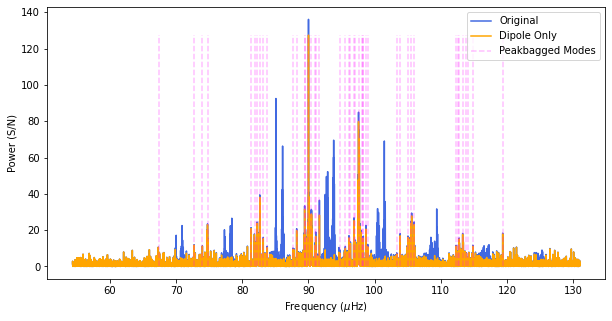

In [5]:
fig = plt.figure(figsize=(10, 5))
plt.plot(pds.frequency.values, pds.power.values, label='Original', color='royalblue')
plt.plot(pds.frequency.values, pds_l023_removed.power.values, label='Dipole Only', color='orange')
plt.vlines(prepped_l1_peaks.frequency.values,ymin=0, ymax=np.max(pds_l023_removed.power.values),
           color='magenta', ls='--', alpha=0.25, label='Peakbagged Modes')
plt.xlabel('Frequency ($\\mu$Hz)')
plt.ylabel('Power (S/N)')
plt.legend()
plt.show()

### We begin with an estimate of $\Delta\Pi$ based on $\Delta\nu$. $\Delta\Pi_{\mathrm{init}}$ and $q_{\mathrm{init}}=0.2$ are used to initialize the optimization in TuRBO by computing stretched periods ($\tau$).

In [6]:
# Initial PSxPS to assess starting point and range for Bayesian Optimisation

# Scaling Guess (RGB only)
print('Scaling Guess: ', DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu))


params = {'calc_l0': True, # Compute radial mode properties
            'calc_l2': True, # Compute l=2 mode properties
            'calc_l3': False, # Don't need to calculate l=3 theoretical freqs
            'calc_nom_l1': True, # Compute nominal l=1 p-mode properties
            'calc_mixed': False, # Don't compute mixed modes (as not needed)
            'calc_rot': False, # Don't compute rotation
            'DPi1': DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu),
            'coupling': 0.2,
            'eps_g': 0.0, # Epsilon_g isn't needed for computation of tau due to chosen formulation of zeta
            'l': 1, # Mixed modes are dipole mixed modes
            }
freqs(params)
new_frequency, tau, zeta = mixed_modes_utils.stretched_pds(pds_l023_removed.frequency.values, 
                                                           freqs.zeta)

Scaling Guess:  [73.12607136]


### Let's visualize what the Power Spectrum of the Power Spectrum (PSxPS) looks like! We will take the $\Delta\Pi$ containing the highest peak PSxPS as our initial $\Delta\Pi$ for the subsequent optimization step.

Best initial guess DPi from PSxPS is 85.74416242657071 s with a maximum of 6.7374205181152815


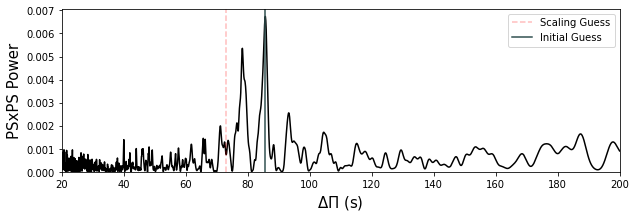

In [7]:
## Bounds for observing the stretched period (tau) 
up_bound, low_bound = 200, 20 # RGB
# up_bound, low_bound = 400, 50 # HeB


fr = np.arange(1/(up_bound), 1/(low_bound), 0.1/tau.max()) # 150, 20 for RGB; 400, 150 for RC

ls = LombScargle(tau, pds_l023_removed.power.values) # computing the LS-periodogram for the tau-spectrum
PSD_LS = ls.power(fr)
plt.figure(figsize=(10, 3))
plt.plot(1/fr, PSD_LS, c='k')
plt.ylim(0, None)
plt.xlim(low_bound, up_bound)
plt.axvline(DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu), alpha=0.26, c='r', ls='--', label='Scaling Guess')
plt.axvline((1/fr)[np.argmax(PSD_LS)], c='darkslategray', label='Initial Guess')


plt.ylabel('PSxPS Power', fontsize=15)
plt.xlabel('$\\Delta\\Pi$ (s)', fontsize=15)
plt.legend()

dpi1_guess = (1/fr)[np.argmax(PSD_LS)]

print(f"Best initial guess DPi from PSxPS is {dpi1_guess} s with a maximum of {np.max(PSD_LS)*1000.}")

### Next, we define the objective function for TuRBO. Here, it is optimizing finding the combination of ($\Delta\Pi,q$) at which you would find the maximum PSxPS Power at $\Delta\Pi$.

In [8]:
class PSXPS:
    def __init__(self, init_dpi, low_bound, up_bound, factor=1):
        
        self.factor = factor
        init_dpi = init_dpi*self.factor
        
        self.lb = np.array([0.8*init_dpi, 0])
        self.ub = np.array([1.2*init_dpi, 0.8])

        self.low_bound = low_bound
        self.up_bound = up_bound
        
    def __call__(self, x):
        assert len(x) == 2
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        
        DPi1, q = x[0], x[1]
        
        params = {'calc_l0': True, 
                'calc_l2': True, 
                'calc_l3': False, 
                'calc_nom_l1': True,
                'calc_mixed': False, 
                'calc_rot': False,
                'DPi1': DPi1,
                'coupling': q,
                'eps_g': 0.0,
                'l': 1,
                }
        freqs(params)
        
        if pds_l023_removed.frequency.min() < freqs.l0_freqs.min():
            zeta = freqs.zeta[pds_l023_removed.frequency >= freqs.l0_freqs.min()]
            power = pds_l023_removed.power[pds_l023_removed.frequency >= freqs.l0_freqs.min()].values
            freq = pds_l023_removed.frequency[pds_l023_removed.frequency >= freqs.l0_freqs.min()].values
        else:
            power = pds_l023_removed.power.values
            freq = pds_l023_removed.frequency.values
            zeta = freqs.zeta
        
        new_frequency, tau, zeta = mixed_modes_utils.stretched_pds(freq, 
                                                                   zeta)

        f = np.arange(1/(self.up_bound), 1/(self.low_bound), 0.1/tau.max())
        ls = LombScargle(tau, power)
        PSD_LS = ls.power(f)
        cut_PSD_LS = PSD_LS[(1/f > self.low_bound) & (1/f < self.up_bound)]
        cut_f = f[(1/f > self.low_bound) & (1/f < self.up_bound)]
        
        return -(cut_PSD_LS*1000.)[np.argmin(np.abs((1/cut_f) - (1./self.factor)*DPi1))]

### The following is a trick to deal with harmonics in the PSxPS. In such cases the highest peak is at a multiple of true $\Delta\Pi$. 

In [9]:
if dpi1_guess < 30: # This is a trick to deal with harmonics in the PSxPS
    factor = 3.
elif dpi1_guess < 50:
    factor = 2
else:
    factor = 1

### The inputs into the objective function concern the range over which to search:

`init_dpi`: We find that searching in an a priori informed region works very well in guaranteeing convergence to a good solution within a few epochs. Here we select the initial value to be $\Delta\Pi_{\mathrm{init}}$, which is an estimate based on $\Delta\nu$.

`up_bound`: The upper bound of the PSxPS we are generating. Here, we set it to 200s because we do not expect $\Delta\Pi$ for RGB stars to exceed this value.

`low_bound`: The upper bound of the PSxPS we are generating, which we set to 20s. We do not expect $\Delta\Pi$ for RGB stars to dip below this value.

`factor`: A scaling factor to deal with harmonics in the PSxPS.

In [10]:
f = PSXPS(init_dpi = dpi1_guess, up_bound=up_bound, low_bound=low_bound, factor = factor)

### Now we run Turbo1!

In [12]:
turbo1 = Turbo1(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=10,  # Number of initial bounds from an Latin hypercube design, 100 default
    max_evals =310,  # Maximum number of evaluations, 2000 default
    batch_size=10,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=64,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

init_time = timer.time()
turbo1.optimize()
print('Elapsed Time: ', timer.time()-init_time)

Using dtype = torch.float64 
Using device = cpu
Starting from fbest = -2.546
20) New best: -3.364 Solution: [85.79171224  0.28869624]
30) New best: -4.997 Solution: [87.44427961  0.27380975]
50) New best: -6.491 Solution: [86.77220782  0.22792993]
60) New best: -6.705 Solution: [87.05707     0.15981583]
70) New best: -6.763 Solution: [86.98863048  0.17730851]
110) New best: -6.763 Solution: [86.97737775  0.17582925]
130) New best: -6.765 Solution: [86.89715543  0.1756406 ]
140) Restarting with fbest = -6.765
Starting from fbest = -6.311
250) Restarting with fbest = -6.765
Starting from fbest = -4.567
Elapsed Time:  8.992563962936401


In [13]:
X = turbo1.X  # Evaluated points
fX = turbo1.fX.ravel()  # Observed values

ind_best = np.argmin(fX) # Selecting the pair of (DPi, q) that maximizes the PSxPS power
f_best, x_best = fX[ind_best], X[ind_best, :]

print("Maximum PSxPS power:\n\tf(x) = %.3f\nObserved at:\n\t(DPi, q) = %s" % (-f_best, np.around(x_best, 3)))

Maximum PSxPS power:
	f(x) = 6.765
Observed at:
	(DPi, q) = [86.897  0.176]


### This gives us the optimal ($\Delta\Pi, q$) from the PSxPS method. To see how this fares with our earlier guess, let's plot and compare! The optimal $\Delta\Pi$ occurs at the highest peak of the PSxPS, and the best $q$ strengthens the power of this peak.

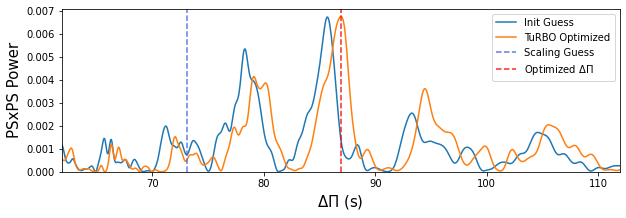

In [14]:
sols_dpi = [DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu), np.around(x_best, 3)[0]] 
sols_q = [0.2, np.around(x_best, 3)[1]]
sols_label = ['Init Guess', 'TuRBO Optimized']

plt.figure(figsize=(10, 3))

for dpix, qx, labelx in zip(sols_dpi, sols_q, sols_label):

    params = {'calc_l0': True, # Compute radial mode properties
                'calc_l2': True, # Compute l=2 mode properties
                'calc_l3': False, # Don't need to calculate l=3 theoretical freqs
                'calc_nom_l1': True, # Compute nominal l=1 p-mode properties
                'calc_mixed': False, # Don't compute mixed modes (as not needed)
                'calc_rot': False, # Don't compute rotation
                'DPi1': dpix,
                'coupling': qx,
                'eps_g': 0.0, # Epsilon_g isn't needed for computation of tau due to chosen formulation of zeta
                'l': 1, # Mixed modes are dipole mixed modes
                }
    freqs(params)
    new_frequency, tau, zeta = mixed_modes_utils.stretched_pds(pds_l023_removed.frequency.values, 
                                                               freqs.zeta)
    
    fr = np.arange(1/(up_bound), 1/(low_bound), 0.1/tau.max()) # 150, 20 for RGB; 400, 150 for RC

    ls = LombScargle(tau, pds_l023_removed.power.values) # computing the LS-periodogram for the tau-spectrum
    PSD_LS = ls.power(fr)

    plt.plot(1/fr, PSD_LS, label=labelx)
plt.ylim(0, None)
plt.xlim(np.around(x_best, 3)[0]-25, np.around(x_best, 3)[0] + 25)
plt.axvline(DeltaPi1_from_DeltaNu_RGB(freqs.delta_nu), alpha=0.86, c='royalblue', ls='--', label='Scaling Guess')
plt.axvline(np.around(x_best, 3)[0], alpha=0.86, c='r', ls='--', label='Optimized $\\Delta\\Pi$')

# plt.axvline((1/fr)[np.argmax(PSD_LS)], c='darkslategray', label='Initial Guess')


plt.ylabel('PSxPS Power', fontsize=15)
plt.xlabel('$\\Delta\\Pi$ (s)', fontsize=15)
plt.legend()
plt.show()

### Optional: You can look at TuRBO beneath its hood and find out how it has learned to model the ($\Delta\Pi, q$) parameter space to find the optimum.

### This requires gpytorch, which is present within TuRBO itself.

In [15]:
sampler = qmc.Sobol(d=2, scramble=True, seed=1337) # Sobol sample the (DPi, q) parameter space 
sample = sampler.random_base2(m=15)
l_bounds = f.lb
u_bounds = f.ub
        
samples = qmc.scale(sample, l_bounds, u_bounds)
idx = np.argsort(samples[:,0])
samp_sob = samples[idx]

samples = to_unit_cube(samp_sob, l_bounds, u_bounds) # convert parameter space to unit hypercube used by TuRBO
samples

assert samples.min() >= 0.0 and samples.max() <= 1.0

In [16]:
import torch, gpytorch
with torch.no_grad(), gpytorch.settings.max_cholesky_size(turbo1.max_cholesky_size):
    X_cand_torch = torch.tensor(samples)#.cuda()#.to(device=device, dtype=dtype)
    y_cand = turbo1.best_gp.likelihood(turbo1.best_gp(X_cand_torch))
mu = y_cand.mean.data.cpu().numpy()

### The contours shows the parameter space as modelled by the GP inside TuRBO, with brighter colors indicating a more optimal solution, namely regions where the peak of the PSxPS at that $\Delta\Pi$ is higher. The objective is framed a *minimization* objective, and so the lower the modelled GP score, the better.

In blue are points that are actually sampled in the ($\Delta\Pi, q$) parameter space. Note that only a fraction of the parameter space is sampled in order for the optimizer to model the 2D space! 

The sampling becomes more dense the closer the optimizer gets to the global minimum, and this is linked to the tendency of the algorithm to exploit the region further to find an even better optimum in the vicinity. The pink dot is the best solution that is found after a measly 300 iterations in this parameter space.

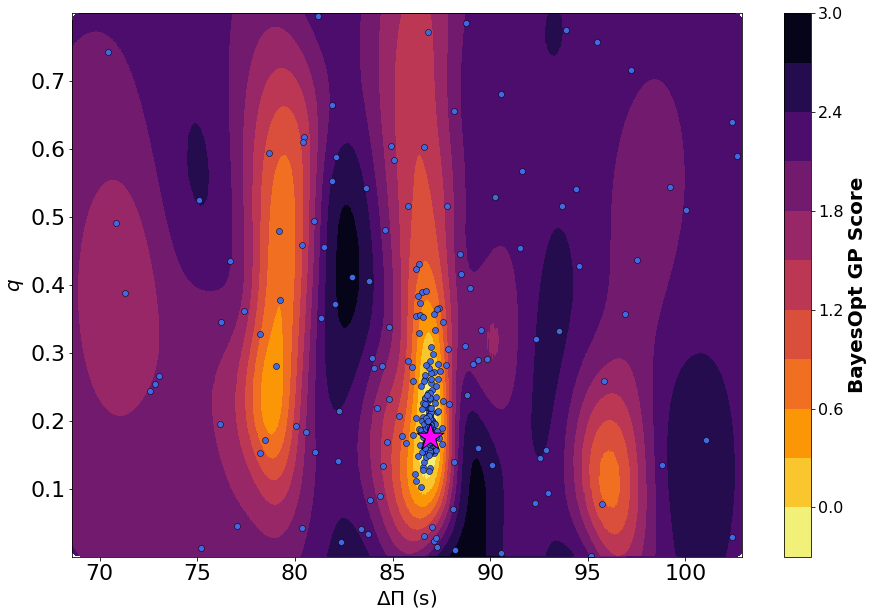

In [17]:
fig = plt.figure(figsize=(15,10))
levels = [np.percentile(mu, ix) for ix in [1, 5, 33]]
ax1 = fig.add_subplot(111)

im = ax1.tricontourf(samp_sob[:,0], samp_sob[:,1], mu, levels=10, cmap='inferno_r')
# ax1.axvline(x_best[0], color='k', linestyle='--', alpha=0.5);
# ax1.axhline(x_best[1], color='k', linestyle='--', alpha=0.5);
ax1.scatter(X[:,0], X[:,1], c='royalblue', edgecolor='k', lw=0.5)
ax1.scatter(x_best[0], x_best[1], c='magenta', edgecolor='k', lw=1, s=805, marker='*')
ax1.tick_params(labelsize=22)
cb1 = fig.colorbar(im, ax=ax1)
cb1.set_label(label='BayesOpt GP Score',weight='bold', fontsize=20)
cb1.ax.tick_params(labelsize=16) 
ax1.set_xlabel('$\\Delta\\Pi$ (s)', fontsize=20)
ax1.set_ylabel('$q$', fontsize=20)
plt.show()